In [27]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random
from scipy import stats
from scipy.optimize import fmin


import mpld3
mpld3.enable_notebook()
figsize = (8,5)
%matplotlib inline
#figsize = (12, 8)

# Quantile estimation via Stochastic gradient descent (Robbins Monro)

Let $(X_n)_n$ be a sequence of i.i.d. real-valued random variables distributed like $X$. Let $(\eta_n)_n$ be
a non-increasing sequence of positive numbers (the step sizes). Finally, let
$H:\mathbb{R}^2\mapsto\mathbb{R}$ be a function. We consider the Robbins-Monro
algorithm:
\begin{equation*}
  x_{k+1}=x_k-\gamma_{k}H(x_k,X_{k+1})
\end{equation*}and $x_0\in\mathbb{R}$ is the starting point of the algorithm.

Let $p\in(0,1)$. For the quantile estimation problem via the Robbins-Monro algorithm,
we consider the function $$H(x,X)=I( X\leq x)-p.$$ In this
particular case, the RM algorithm is
\begin{equation*}
  x_{k+1}=x_k-\gamma_{k}\big(I(X_{n+1}\leq x_k)-p\big) \mbox{ and } x_0\in\mathbb{R}.
\end{equation*} 
We denote by $q_p$ the quantile of order $p$ of $X$:
\begin{equation*}
  q_p = \min\big(x\in\mathbb{R}:F(x)\geq p\big) \mbox{ where }
  F(x)=\mathbb{P}(X\leq x).
\end{equation*}When $X$ has a cdf $F$ which is continuous and strictly increasing on some interval, $q_p$ is the unique solution to $F(x)=p$.

The pseudo code of the algorithm stopped at step N is:

&nbsp;&nbsp;&nbsp; 1: &nbsp; Choose initial guess $x_0$ <br>
&nbsp;&nbsp;&nbsp;    2: &nbsp; <b>for</b> $k=1,2,\ldots, N$ <b>do</b> <br>
&nbsp;&nbsp;&nbsp;    3:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s_k=I(X_{k+1}\leq x_k)-p$ <br>
&nbsp;&nbsp;&nbsp;    4:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{k+1} = x_k - \gamma_{k+1} s_k$ <br>
&nbsp;&nbsp;&nbsp;    5: &nbsp;  <b>end for</b>

Thanks to SGD, we can make progress right away and continue to make progress as we go through the data set. Therefore, stochastic gradient descent is often preferred to gradient descent or here to the empirical quantile when dealing with large data sets.

Unlike gradient descent, stochastic gradient descent will tend to oscillate <i>near</i> a minimum value rather than continuously getting closer. It may never actually converge to the minimum though. One way around this is to slowly decrease the step size $\gamma_k$ like $1/k$ as the algorithm runs.

### Simulating various densities

From now on, we focus on the median estimation (that is quantile estimation for $p=1/2$). We consider three different types of density such that: one has a cdf with a plateau of length 1 centered in $0$, one has a null density in the median and one having a density equal to $1$ at the median.

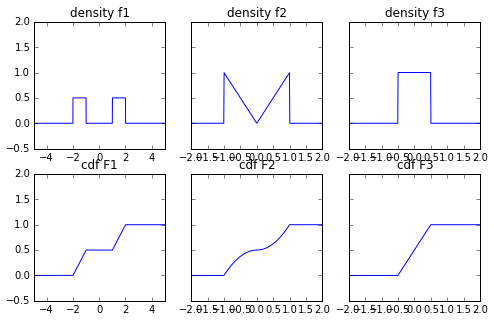

In [28]:
def f1(x):
    if -2<x and x<-1:
        return 0.5
    if 1<x and x<2:
        return 0.5
    else:
        return 0

def F1(x):
    if x<-2:
        return 0
    if -2<=x and x<-1:
        return x*0.5+1
    if -1<=x and x<1:
        return 0.5
    if 1<=x and x<2:
        return x*0.5
    else:
        return 1
    
def f2(x):
    if -1<x and x<0:
        return -x
    if 0<x and x<1:
        return x
    else:
        return 0
    
def F2(x):
    if x<-1:
        return 0
    if -1<=x and x<0:
        return (1-x**2)*0.5
    if 0<=x and x<1:
        return (1+x**2)*0.5
    else:
        return 1

def f3(x):
    if -0.5<x and x<0.5:
        return 1
    else:
        return 0

def F3(x):
    if x<-0.5:
        return 0
    if -0.5<=x and x<0.5:
        return x+0.5
    else:
        return 1

x = np.linspace(-5,5,1000)
y1 = [f1(ele) for ele in x]
y2 = [f2(ele) for ele in x]
y3 = [f3(ele) for ele in x]
y11 = [F1(ele) for ele in x]
y22 = [F2(ele) for ele in x]
y33 = [F3(ele) for ele in x] 
f, axarr = plt.subplots(2, 3, sharey=True, figsize = figsize)
axarr[0, 0].plot(x, y1)
axarr[0, 0].set_xlim([-5,5])
axarr[0, 0].set_ylim([-0.5,2])
axarr[0, 0].set_title('density f1')
axarr[1, 0].plot(x, y11)
axarr[1, 0].set_xlim([-5,5])
axarr[1, 0].set_ylim([-0.5,2])
axarr[1, 0].set_title('cdf F1')

axarr[0, 1].plot(x, y2)
axarr[0, 1].set_xlim([-2,2])
axarr[0, 1].set_ylim([-0.5,2])
axarr[0, 1].set_title('density f2')
axarr[1, 1].plot(x, y22)
axarr[1, 1].set_xlim([-2,2])
axarr[1, 1].set_ylim([-0.5,2])
axarr[1, 1].set_title('cdf F2')

axarr[0, 2].plot(x, y3)
axarr[0, 2].set_xlim([-2,2])
axarr[0, 2].set_ylim([-0.5,2])
axarr[0, 2].set_title('density f3')
axarr[1, 2].plot(x, y33)
axarr[1, 2].set_xlim([-2,2])
axarr[1, 2].set_ylim([-0.5,2])
axarr[1, 2].set_title('cdf F3')

plt.show()

Simulation of a sample from those densities

In [29]:
def S1(n):
    """n-sample of f1"""
    L1 = list()
    i = 0
    while i <n:
        u = np.random.randint(0, 2) # u = bernouilli(1/2)
        v = np.random.random() # v = uniform([0,1])
        L1.append(v+3*u-2) # X = v + (3u-2)
        i+=1
    return L1

def Q2(y):
    """quantile function of f2: Q2(y)=\min(x : F(x)\geq y)"""
    if 0<y and y<0.5:
        return -np.sqrt(1-2*y)
    if 0.5<=y and y<1:
        return np.sqrt(2*y-1)
    

def S2(n):
    """n-sample of f2: X=Q(Unif) -- inverse function method"""
    L2 = list()
    i = 0
    while i<n:
        u = np.random.random()
        L2.append(Q2(u))
        i+=1
    return L2

def S3(n):
    """n-sample of uniform([-0.5,0.5])"""
    return np.random.uniform(-0.5,0.5,n)

##Histogram n-sample according to $f_1,f_2$ and $f_3$

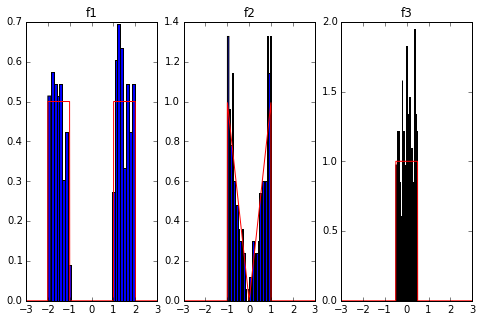

In [30]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = figsize)
x = np.linspace(-3,3,1000)
y1 = [f1(ele) for ele in x]
y2 = [f2(ele) for ele in x]
y3 = [f3(ele) for ele in x]
nb_sample = 250
ax1.hist(S1(nb_sample), normed = True, bins=30)
ax1.plot(x, y1, 'r-')
ax1.set_title('f1')
ax2.hist(S2(nb_sample),normed = True, bins=30)
ax2.plot(x, y2, 'r-')
ax2.set_title('f2')
ax3.hist(S3(nb_sample),normed = True, bins=30)
ax3.plot(x, y3, 'r-')
ax3.set_title('f3')
plt.show()

## Simulating Robbins Monro paths

In [31]:
def RM(theta_0, horizon, data_nb, power_step=0.5):
    """ theta_0 = starting point; horizon : length of the path; data_nb = 1,2,3 for f1,f2,f3; power_step: power in step size"""
    if data_nb == 1:
        data = S1(horizon)
    if data_nb == 2:
        data = S2(horizon)
    if data_nb == 3:
        data = S3(horizon)
    theta = theta_0
    path = list()
    for i in range(horizon):
        gamma_k = 1./(i+1)**power_step # step size k^power_step
        if theta > data[i]:
            s_k = 0.5 # 1-p quand p=1/2 pour la médiane
        else:
            s_k = -0.5
        theta = theta - gamma_k*s_k
        #print data[i], theta
        path.append(theta)
    return path

Now, we plot the path towards the quantile, which is the median here ($=0$ for data_nb = $2$ or $3$ but which is the interval $[-1,1]$ for data_nb = $1$).

###density $f_1$ with a plateau [-1,1] for the median

x10000 = 0.136933289153 -- median = plateau [-1,1]


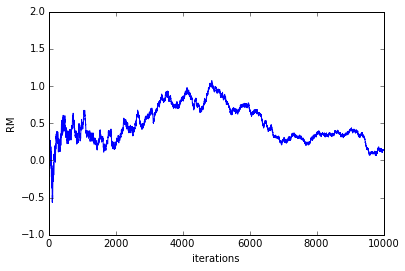

In [32]:
horizon = 10000
theta_0 = 2
path = RM(theta_0, horizon, 1)
print 'x{} = {} -- median = plateau [-1,1]'.format(horizon, path[horizon-1])
#print len(iterations), len(path)
plt.plot(range(horizon), path)
plt.xlabel("iterations")
plt.ylabel("RM")
plt.show()

distribution of the RM $x_n$ (1000 simulations of $x_{5000}$)

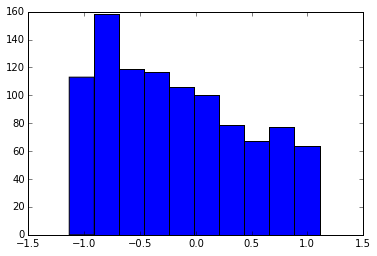

In [33]:
list_theta_limit = list()
horizon = 5000
theta_0=-2
for i in range(1000):
    path = RM(theta_0, horizon, 1)
    list_theta_limit.append(path[horizon-1])

plt.hist(list_theta_limit)
plt.show()    

For the data set 1, it looks like the limit of the RM algo is  either [uniformly distributed over the plateau] or [the limiting law depends  on the starting point (if theta_0 is >0 or <0)]. It is not clear yet. Moreover, it really looks like the limiting depends on the step size and in particular, how fast the serie $\sum_k \gamma_k$ goes to $\infty$.

###density $f_2$ with no plateau for the median but for which f(q_{1/2})=0
For the data set number 2 (for which f(q)=0 but for which there is no plateau), the step size gamma_k=1/k does not lead to the convergence of the algorithm. It works for gamma_k=1/sqrt(k). 

x10000 = -0.136316581064 -- median = 0


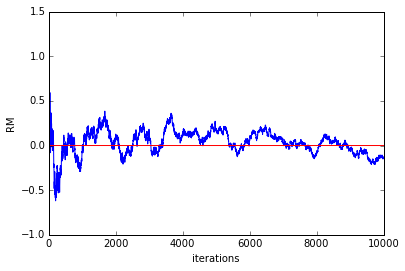

In [34]:
horizon = 10000
theta_0 = 2
path = RM(theta_0, horizon, 2)
print 'x{} = {} -- median = 0'.format(horizon, path[horizon-1])
#print len(iterations), len(path)
plt.plot(range(horizon), path)
plt.xlabel("iterations")
plt.ylabel("RM")
plt.plot(range(horizon), np.zeros(horizon),color = 'r')
plt.show()

distribution of the RM $x_n$ (1000 simulations of $x_{5000}$) -- when $f(q_p)=0$

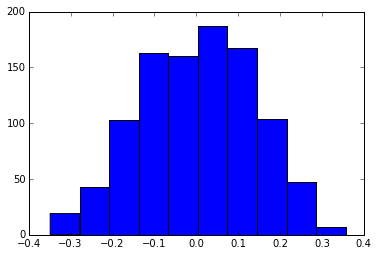

In [35]:
list_theta_limit = list()
horizon = 5000
theta_0=-2
for i in range(1000):
    path = RM(theta_0, horizon, 2)
    list_theta_limit.append(path[horizon-1])

plt.hist(list_theta_limit)
plt.show() 

###density $f_3$ for which the median $=0$ and $f(0)=1$

x10000 = 0.00381726226498 -- median = 0


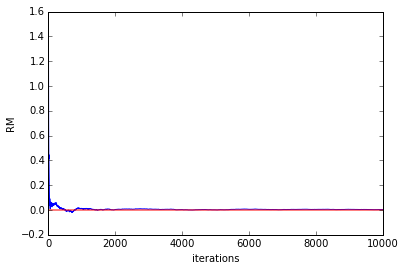

In [36]:
horizon = 10000
theta_0 = 2
path = RM(theta_0, horizon, 3, power_step=1)
print 'x{} = {} -- median = 0'.format(horizon, path[horizon-1])
#print len(iterations), len(path)
plt.plot(range(horizon), path)
plt.xlabel("iterations")
plt.ylabel("RM")
plt.plot(range(horizon), np.zeros(horizon),color = 'r')
plt.show()

distribution of the RM $x_n$ (1000 simulations of $x_{5000}$): when $f(q_p)>1/2$,
$$\sqrt{n}(x_n-q_p)\stackrel{d}{\rightarrow} \mathcal{N}(0,\sigma^2) \mbox{ where } \sigma^2=\frac{p(1-p)}{2f(q_p)-1}$$
Here : $p=1/2$, $q_p=0$, $f(q_p)=1$ and $\sigma^2=1/4$ and so
$$x_n\approx \mathcal{N}(0,1/(4n))$$

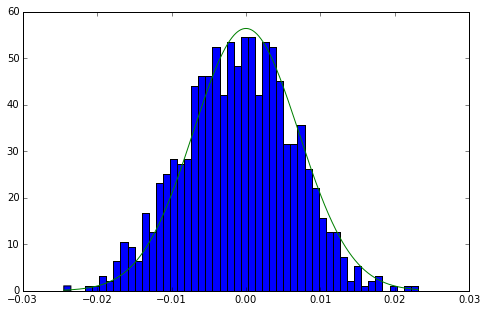

In [37]:
from scipy.stats import norm
list_theta_limit = list()
horizon = 5000
theta_0=-2
nb_paths = 1000
for i in range(nb_paths):
    path = RM(theta_0, horizon, 3, power_step=1)
    list_theta_limit.append(path[horizon-1])
####Gaussian limit
Fx = 0
var = 1/float(4)
x = np.linspace(min(list_theta_limit), max(list_theta_limit), 1000)
y = norm.pdf(x, loc = Fx, scale = np.sqrt(var/float(horizon)))
####Plot
f, ax = plt.subplots(1, 1, figsize = figsize)
ax.hist(list_theta_limit, normed=True, bins=50)
ax.plot(x,y)
plt.show() 

##Comparison of estimators $x_n$ (RM) and empirical quantile $\widehat q_{n,p}$ for density $f_3$

###limit law of empirical quantile
$$\sqrt{n}(\widehat q_{n,p}-q_p)\stackrel{d}{\rightarrow}\mathcal{N}(0,\sigma^2)$$
where $\sigma^2= p(1-p)/f(q_p)^2$. 
    
Here: $p=1/2$, $q_p=0$, $f(q_p)=1$ and $\sigma^2=1/4$


horizon = 500, number of paths=1000


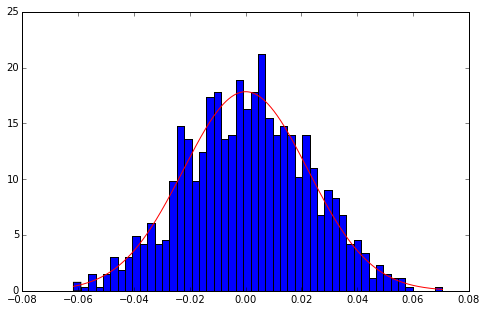

In [19]:
from scipy.stats import norm
#paramètres
nb_paths, horizon, bins = 1000, 500, 20
print 'horizon = {}, number of paths={}'.format(horizon, nb_paths)
#data
Hatq = list()
for j in range(nb_paths):
    data0 = S3(horizon)
    Hatq.append(np.median(data0))
#Gaussienne
Fx = 0
var = 1/float(4)
x = np.linspace(min(Hatq), max(Hatq), 1000)
y = norm.pdf(x, loc = Fx, scale = np.sqrt(var/float(horizon)))
#plot
f, ax = plt.subplots(1,1,figsize = figsize)
ax.hist(Hatq, bins = 50, normed = True)
ax.plot(x, y, 'r')
#ax.set_title('x = {}, var = {}'.format(x, var))
plt.show()

###Comparing the speed of convergence of $\widehat q_{n,p}$ and $x_n$
Here, for the median of $f_3$ both $\widehat q_{n,p}$ and $x_n$ converge towards $q_p=0$ at the speed of $1/\sqrt{n}$ with the same asymptotic variance = 1/4. 

horizon = 10000 
 quantile = 0.00577366960229
 RM = 0.00534791670922
 theoretical median = 0


/Users/lecueguillaume/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/lecueguillaume/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


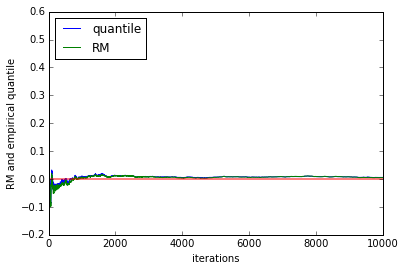

In [20]:
horizon = 10000
data = S3(horizon)
power_step = 1 # the limit law for power_step = 1/2 is not classical
#######RM
theta = 1
path_RM = list()
for i in range(horizon):
    gamma_k = 1./(i+1)**power_step # step size 1/sqrt(k)
    if theta > data[i]:
        s_k = 0.5 # 1-p quand p=1/2 pour la médiane
    else:
        s_k = -0.5
    theta = theta - gamma_k*s_k
    #print data[i], theta
    path_RM.append(theta)
#######empirical quantile
path_quant = []
for i in range(horizon):
    path_quant.append(np.median(data[0:i]))
########plot    
print 'horizon = {} \n quantile = {}\n RM = {}\n theoretical median = 0'.format(horizon, path_quant[horizon-1], path_RM[horizon-1])
#print len(iterations), len(path)
plt.plot(range(horizon), path_quant, color = 'b', label = 'quantile')
plt.plot(range(horizon), path_RM, color = 'g', label = 'RM')
plt.xlabel("iterations")
plt.ylabel("RM and empirical quantile")
plt.plot(range(horizon), np.zeros(horizon),color = 'r')
plt.legend(loc = 2)
plt.show()

Warm start for RM : start with $\widehat q_{n,1/2}$ for $n=20$

Open question : non-asymptotic convergence result for Robbins-Monro ?

#Study of the Robbins-Monro algorithm for density $f_3$ (uniform over $[-0.5, 0.5]$) depending on the power in the step size ($=1/k^a$):

$$x_{k+1} = x_k - \eta_k(I(X_{k+1}\leq x_k)-p) \mbox{ for } \eta_k=\frac{1}{k^a} \mbox{ and } a\in[1/2,1]$$

Asymptotic normality of the RM algorithm is known only when the step size is such that 
$$\sum_k \eta_k = +\infty \mbox{ and } \sum_k \eta_k^2<\infty$$

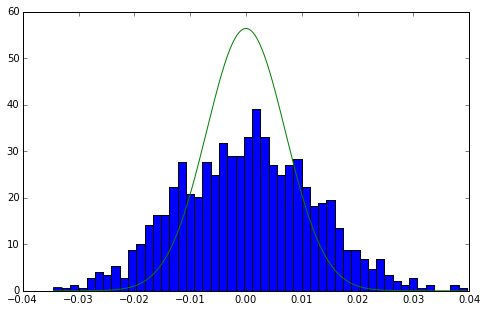

In [21]:
import IPython.html.widgets as widgets
from IPython.html.widgets import interact, interactive, fixed
horizon = 5000
theta_0=-2
nb_paths = 1000

@interact(a=(0.5, 1))
def generate(a):
    list_theta_limit = list()
    for i in range(nb_paths):
        path = RM(theta_0, horizon, 3, power_step=a)
        list_theta_limit.append(path[horizon-1])
    ####Gaussian limit
    Fx = 0
    var = 1/float(4)
    x = np.linspace(min(list_theta_limit), max(list_theta_limit), 1000)
    y = norm.pdf(x, loc = Fx, scale = np.sqrt(var/float(horizon)))
    ####Plot
    f, ax = plt.subplots(1, 1, figsize = figsize)
    ax.hist(list_theta_limit, normed=True, bins=50)
    ax.plot(x,y)
    plt.show()   